# Project KALM: Kalman-based Adaptive Linear Modeling

**Objective:** Use a Kalman filter to estimate a clean, time-varying random signal from noisy measurements.

This notebook leverages **PySDR** for noise generation and analysis.


## 1. Import Required Libraries

In [981]:
import numpy as np
import matplotlib.pyplot as plt

# Custom utils
import sys
sys.path.append('../src')
from utils import *

## 2. Simulate Time-Varying Noisy Signal

In [982]:
# TODO: Simulate a random walk (or similar) dynamic process
import sympy as sym


def v(*elms):
    return np.array([[elm] for elm in elms])


def rand_v(mean_v, cov_mat, length):
    return np.random.multivariate_normal(mean_v.T[0], cov_mat, length).reshape(
        length, -1, 1
    )


c = 3e8
f = 2.4e9

initial_pos_std = 1000
initial_vel_std = 20

accel_std = 5

delta_f_std = 60
delta_t_std = 1e-6


n_measurements = 1000
n_states = 2


dt = 0.1
accel_var = v(accel_std**2)

initial_state_guess = v(0, 0)

G = v(
    dt**2 / 2,
    dt,
)

F = np.array(
    [
        [1, dt],
        [0, 1],
    ]
)

H = np.array(
    [
        [1 / c, 0],
        [0, f / c],
    ]
)

In [983]:
x_est = np.zeros((n_measurements, n_states, 1))
P = np.zeros((n_measurements, n_states, n_states))

x_est[0] = initial_state_guess
P[0] = np.diag([initial_pos_std**2, initial_vel_std**2])

Q = G @ accel_var @ G.T

R = np.diag([delta_t_std**2, delta_f_std**2])

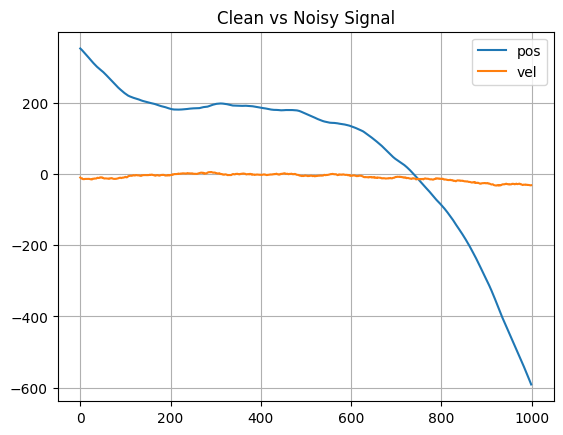

In [984]:
ts = np.arange(n_measurements) * dt

actual_accel = rand_v(v(0), accel_var, n_measurements - 1)
initial_state = rand_v(x_est[0], P[0], 1)


actual_state = np.zeros((n_measurements, n_states, 1))
actual_state[0] = initial_state
for k in range(1, n_measurements):
    accel_effect = G * actual_accel[k - 1]
    actual_state[k] = F @ actual_state[k - 1] + accel_effect


# Add noise
plt.figure()
plt.plot(actual_state[:, 0], label="pos")
plt.plot(actual_state[:, 1], label="vel")
plt.legend()
plt.title("Clean vs Noisy Signal")
plt.grid()
plt.show()

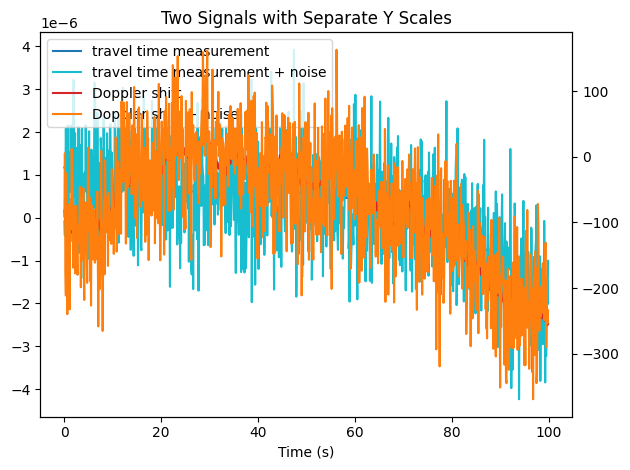

In [985]:
# Add noise
clean_measurements = np.array([H @ state for state in actual_state])

measurement_noise = rand_v(v(*np.zeros(2)), R, n_measurements)

noisy_signal = clean_measurements + measurement_noise
fig, ax1 = plt.subplots()

# Plot the first signal on the primary y-axis
ax1.plot(ts, clean_measurements[:, 0], label="travel time measurement")
ax1.plot(
    ts, noisy_signal[:, 0], color="tab:cyan", label="travel time measurement + noise"
)
ax1.set_xlabel("Time (s)")
# ax1.set_ylabel('Amplitude (sin)', fontsize=12)
ax1.tick_params(axis="y")

# Create a secondary y-axis sharing the same x-axis
ax2 = ax1.twinx()
ax2.plot(ts, clean_measurements[:, 1], color="tab:red", label="Doppler shift")
ax2.plot(ts, noisy_signal[:, 1], color="tab:orange", label="Doppler shift + noise")
# ax2.set_ylabel('Amplitude (exp)', fontsize=12)
ax2.tick_params(axis="y")

# Add legends for both plots
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper left")

# Add a title and show the plot
plt.title("Two Signals with Separate Y Scales")
plt.tight_layout()

## 3. Implement Kalman Filter

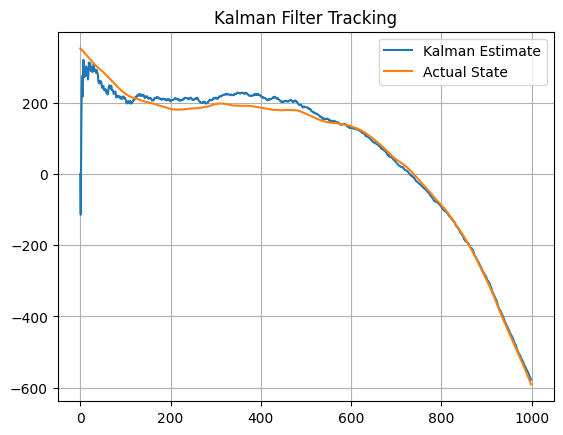

In [986]:
# TODO: Implement a simple Kalman filter for 1D tracking
# Initialize variables
import numpy.linalg as lalg

for k in range(1, n_measurements):
    # Predict
    x_pred = F @ x_est[k - 1]
    P_pred = F @ P[k - 1] @ F.T + Q

    # Update
    K = P_pred @ H @ lalg.inv(H @ P_pred @ H.T + R)
    x_est[k] = x_pred + K @ (noisy_signal[k] - H @ x_pred)
    P[k] = (np.eye(2) - K @ H) @ P_pred

x_est_s = np.reshape( x_est, (n_measurements,2))
actual_state_s = np.reshape( actual_state, (n_measurements,2))

plt.figure()
plt.plot(x_est_s[:,0], label="Kalman Estimate")
plt.plot(actual_state_s[:,0], label="Actual State")

plt.legend()
plt.title("Kalman Filter Tracking")
plt.grid()
plt.show()

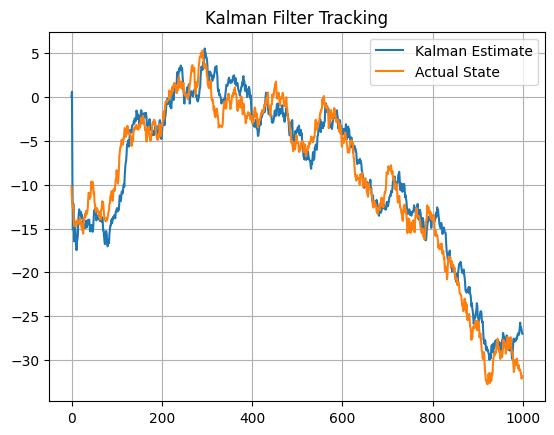

In [987]:
plt.figure()
plt.plot(x_est_s[:,1], label="Kalman Estimate")
plt.plot(actual_state_s[:,1], label="Actual State")

plt.legend()
plt.title("Kalman Filter Tracking")
plt.grid()
plt.show()

## 4. Error Convergence Visualization

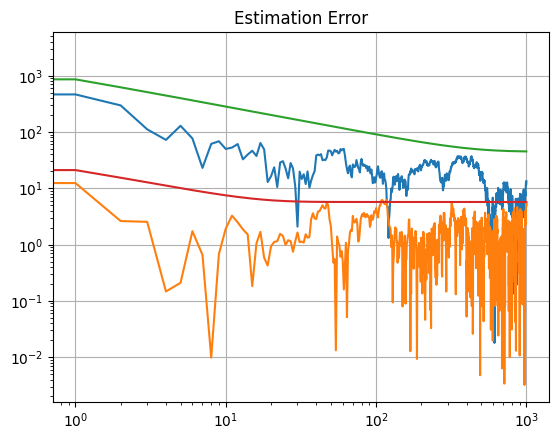

In [988]:
error = actual_state_s - x_est_s
plt.figure()
plt.loglog(np.abs(error))
plt.loglog(3 * np.sqrt(P.diagonal(axis1=1, axis2=2)))
plt.plot
plt.title('Estimation Error')
plt.grid()
plt.show()

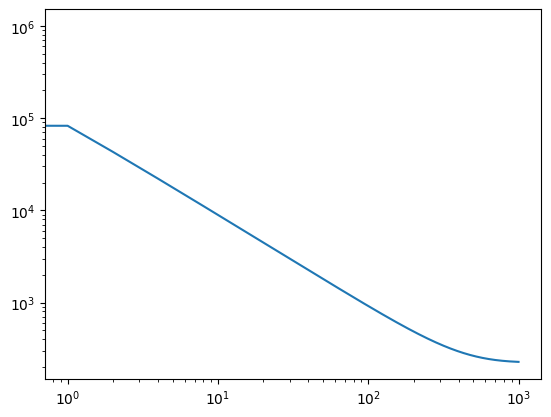

In [989]:
plt.loglog(P[:,0,0])

## 5. Reflection
- How does the Kalman filter adapt to the noisy measurements?
- Real-world applications: tracking, sensor fusion, etc.